## Input

In [1]:
location = "NewYorkNY" # Location will be defined in main notebook

## Libraries

In [2]:
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import itertools
import pickle

## Data

In [3]:
df_raw = pd.read_pickle('cleaned_df.pkl')

In [4]:
# define df for chosen region
df = df_raw[["date", location]] # subset
df.columns = ["ds", "y"] # rename columns to work with prophet

# drop nas because they just mean the time series is shorter (nans within time series were already interpolated)
df = df.dropna(axis=0)
df = df.reset_index(drop=True)

## Model

In [5]:
# fit model
m = Prophet(changepoint_range=0.9, 
            changepoint_prior_scale=0.5,
            yearly_seasonality = False
           ).fit(df)

18:30:41 - cmdstanpy - INFO - Chain [1] start processing
18:30:41 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
# create list called future containing df with future dates
future = m.make_future_dataframe(periods=12, freq='MS')

# create list called forecast containing df with forecasts
forecast = m.predict(future)

## Plot

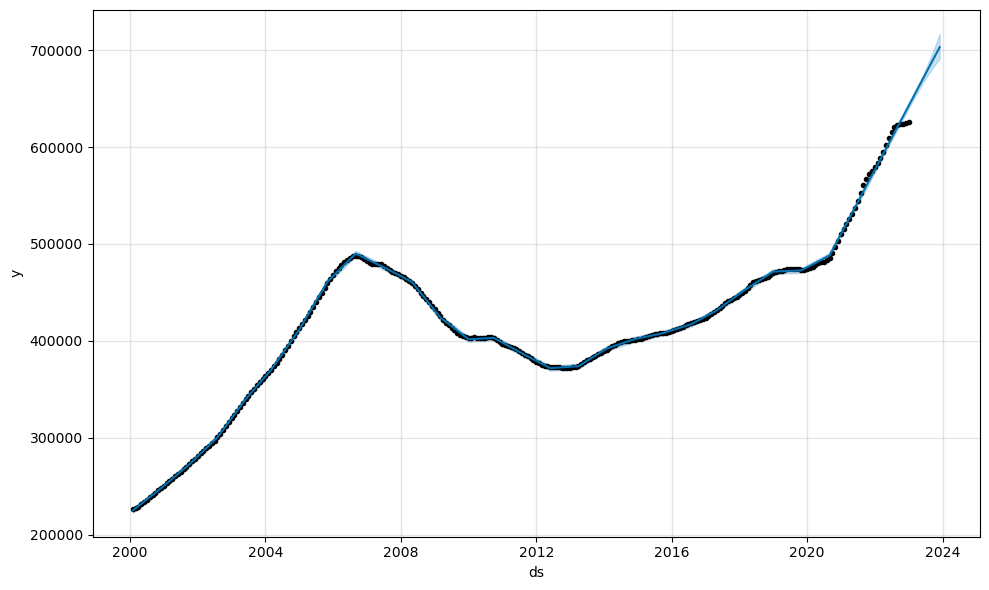

In [7]:
fig1 = m.plot(forecast)

## Performance
Using cross validation

In [8]:
# create cutoffs - make appropriate depending on length of time series
last_day = pd.to_datetime(df["ds"].iloc[-1])

# for time series shorter than 3 years
    # horizon = 4 months
    # initial = 6 months
    # period = 1 month
if len(df) <= 36:
    cutoff_index = 6-1 # initial
    cutoffs = []
    # while the cut off is less than the end date minus horizon:
    while df["ds"].iloc[cutoff_index] <= last_day-pd.DateOffset(122):
        cutoff = df["ds"].iloc[cutoff_index]
        cutoffs.append(cutoff) # add cutoff to the list
        cutoff_index += 1 # cutoff every month
    cutoffs = pd.to_datetime(cutoffs) # to datetime
    horizon = "122 days" # 4 months

# for time series longer than 4 years
    # horizon = 12 months
    # initial = half the length of the time series but at least 3 years
    # period = 6 month
if len(df) > 36:
    cutoff_index = max(24, round(len(df)/2))-1 # initial - at least 2 yrs
    cutoffs = []
    # while the cut off is less than the end date minus horizon:
    while df["ds"].iloc[cutoff_index] <= last_day-pd.DateOffset(366): # cutoffs must be less than end date minus horizon
        cutoff = df["ds"].iloc[cutoff_index]
        cutoffs.append(cutoff) # add cutoff to the list
        cutoff_index += 6 # cutoff every 6 months
    cutoffs = pd.to_datetime(cutoffs) # to datetime
    horizon = "366 days" # 1 year

In [9]:
# Use cross validation to evaluate performance
df_cv = cross_validation(m, cutoffs=cutoffs, horizon=horizon)
df_p = performance_metrics(df_cv)

  0%|          | 0/21 [00:00<?, ?it/s]

18:30:42 - cmdstanpy - INFO - Chain [1] start processing
18:30:42 - cmdstanpy - INFO - Chain [1] done processing
18:30:42 - cmdstanpy - INFO - Chain [1] start processing
18:30:42 - cmdstanpy - INFO - Chain [1] done processing
18:30:42 - cmdstanpy - INFO - Chain [1] start processing
18:30:42 - cmdstanpy - INFO - Chain [1] done processing
18:30:42 - cmdstanpy - INFO - Chain [1] start processing
18:30:42 - cmdstanpy - INFO - Chain [1] done processing
18:30:42 - cmdstanpy - INFO - Chain [1] start processing
18:30:42 - cmdstanpy - INFO - Chain [1] done processing
18:30:42 - cmdstanpy - INFO - Chain [1] start processing
18:30:42 - cmdstanpy - INFO - Chain [1] done processing
18:30:42 - cmdstanpy - INFO - Chain [1] start processing
18:30:43 - cmdstanpy - INFO - Chain [1] done processing
18:30:43 - cmdstanpy - INFO - Chain [1] start processing
18:30:43 - cmdstanpy - INFO - Chain [1] done processing
18:30:43 - cmdstanpy - INFO - Chain [1] start processing
18:30:43 - cmdstanpy - INFO - Chain [1]

In [10]:
# I want df_p in months
df_p["horizon"] = round(df_p["horizon"]/np.timedelta64(1, 'M')) # round days to months
df_p = df_p.groupby(["horizon"], as_index=False).mean() # average values for each month

## Plot MAPE

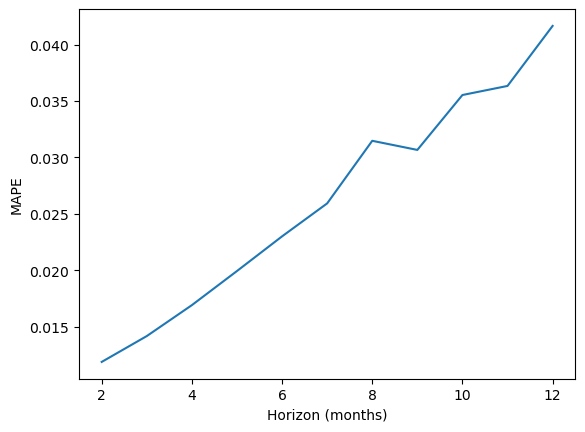

In [11]:
fig2 = df_p.plot(x="horizon", y="mape", ylabel="MAPE", xlabel="Horizon (months)", legend=0)